### Importing libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12,6)

### Loading Data

In [3]:
df = pd.read_csv('real-gdp-growth.csv')
df.head(5)

,Entity,Code,Year,"Gross domestic product, constant prices - Percent change - Observations",1120034-annotations,"Gross domestic product, constant prices - Percent change - Forecasts",1120032-annotations
0,ASEAN-5 (IMF),NaN,1980,7.557,"Indonesia, Malaysia, Philippines, Singapore, T...",NaN,NaN
1,ASEAN-5 (IMF),NaN,1981,6.493,"Indonesia, Malaysia, Philippines, Singapore, T...",NaN,NaN
2,ASEAN-5 (IMF),NaN,1982,3.850,"Indonesia, Malaysia, Philippines, Singapore, T...",NaN,NaN
3,ASEAN-5 (IMF),NaN,1983,4.488,"Indonesia, Malaysia, Philippines, Singapore, T...",NaN,NaN
4,ASEAN-5 (IMF),NaN,1984,4.552,"Indonesia, Malaysia, Philippines, Singapore, T...",NaN,NaN


In [4]:
# 1. Inspect Column Names (To ensure we map them correctly)
print("Original Columns:")
print(df.columns.tolist())

# 2. Define a renaming dictionary
# We map the LONG original name to a SHORT new name
# Note: Adjust the keys below exactly as they appear in the print output above if needed
rename_map = {
    'Entity': 'Country',
    'Code': 'ISO_Code',
    'Gross domestic product, constant prices - Percent change - Observations': 'GDP_Growth_Observed',
    'Gross domestic product, constant prices - Percent change - Forecasts': 'GDP_Growth_Forecast'
}

# 3. Apply renaming
df.rename(columns=rename_map, inplace=True)

# 4. Combine Observed and Forecast data into a single 'GDP_Growth' column
# Logic: If Observed is NaN, use Forecast. If Forecast is NaN, use Observed.
df['GDP_Growth'] = df['GDP_Growth_Observed'].combine_first(df['GDP_Growth_Forecast'])

# 5. Drop unnecessary columns (Annotations and the now redundant split columns)
cols_to_drop = [col for col in df.columns if 'annotations' in col]
cols_to_drop.extend(['GDP_Growth_Observed', 'GDP_Growth_Forecast'])

df.drop(columns=cols_to_drop, inplace=True)

# 6. Final Clean Inspection
print("\nData cleaned successfully!")
df.info()
df.head()

Original Columns:
['Entity', 'Code', 'Year', 'Gross domestic product, constant prices - Percent change - Observations', '1120034-annotations', 'Gross domestic product, constant prices - Percent change - Forecasts', '1120032-annotations']

Data cleaned successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9620 entries, 0 to 9619
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     9620 non-null   object 
 1   ISO_Code    9184 non-null   object 
 2   Year        9620 non-null   int64  
 3   GDP_Growth  9620 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 300.8+ KB


,Country,ISO_Code,Year,GDP_Growth
0,ASEAN-5 (IMF),NaN,1980,7.557
1,ASEAN-5 (IMF),NaN,1981,6.493
2,ASEAN-5 (IMF),NaN,1982,3.850
3,ASEAN-5 (IMF),NaN,1983,4.488
4,ASEAN-5 (IMF),NaN,1984,4.552


#### 4. Feature Engineering: Global Developing vs. Global Developed
To achieve the objective of comparing the "Global South" with developed economies, we need to categorize each country.

Since the dataset does not explicitly provide this classification, we will create a new column Region_Type based on ISO Codes.

Global Developed: Includes major advanced economies (G7, Western Europe, Australia, NZ, etc.).
Global Developing: Includes emerging and developing economies (Brazil, India, China, African nations, Latin America, etc.).
Note: We filter out rows with missing ISO Codes, as these typically represent aggregate regions (e.g., "ASEAN-5", "European Union") rather than individual countries.


In [5]:
# 1. Filter Data: Keep only actual countries (Rows with a valid ISO_Code)
# Entries like "ASEAN-5" or "Middle East" usually have NaN ISO_Code
countries_df = df.dropna(subset=['ISO_Code']).copy()

# 2. Define a list of "Global Developed" (Developed) ISO Codes
# Based on IMF/World Bank definition of Advanced Economies
global_developed_codes = [
    'USA', 'CAN', 'GBR', 'DEU', 'FRA', 'ITA', 'JPN',  # G7
    'AUS', 'NZL', 'CHE', 'NOR', 'SWE', 'DNK', 'FIN',  # Oceania & Scandi
    'ISL', 'IRL', 'NLD', 'BEL', 'AUT', 'ESP', 'PRT',  # Western Europe
    'SGP', 'HKG', 'ISR', 'KOR', 'TWN'                 # Asian Tigers/Advanced
]

# 3. Apply Classification Logic
# If the code is in the list -> Global Developed, Else -> Global Developing
countries_df['Category'] = countries_df['ISO_Code'].apply(
    lambda x: 'Global Developed' if x in global_developed_codes else 'Global Developing'
)

# 4. Validation
print("Category Distribution:")
print(countries_df['Category'].value_counts())

# Preview a sample of Global Developing countries (to check if India is there)
print("\nSample of Global Developing:")
print(countries_df[countries_df['Category'] == 'Global Developing']['Country'].unique()[:10])

# Preview a sample of Global Developed countries
print("\nSample of Global Developed:")
print(countries_df[countries_df['Category'] == 'Global Developed']['Country'].unique()[:10])


Category Distribution:
Category
Global Developing    7859
Global Developed     1325
Name: count, dtype: int64

Sample of Global Developing:
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Azerbaijan']

Sample of Global Developed:
['Australia' 'Austria' 'Belgium' 'Canada' 'Denmark' 'Finland' 'France'
 'Germany' 'Hong Kong' 'Iceland']


#### 5. Exploratory Data Analysis: Temporal Trends (1980-2030)

 Objective:

To visualize the disparity and correlation in economic growth between the Global Developed and the Global Developing over the last 40 years, and project future trends up to 2030.

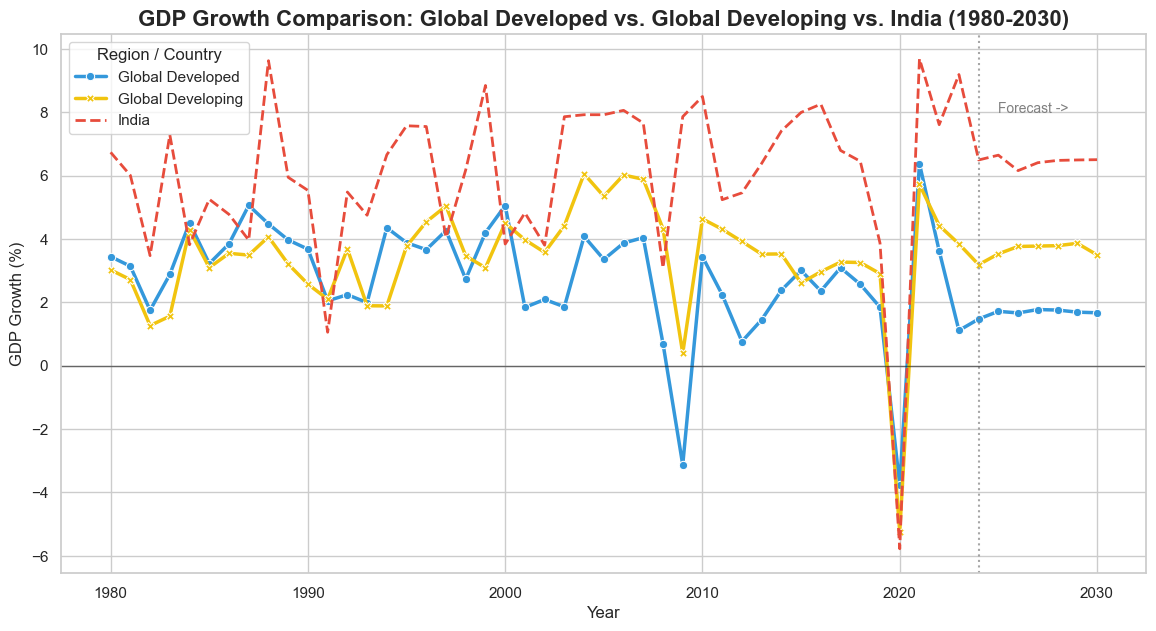

In [6]:
# 1. Aggregate Data: Calculate Mean GDP Growth per Year for each Category
# This gives us the "trend line" for the blocks
annual_trends = countries_df.groupby(['Year', 'Category'])['GDP_Growth'].mean().reset_index()

# 2. Isolate India Data for highlighting
India_data = countries_df[countries_df['Country'] == 'India']

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot the Global Groups (Developed vs Developing)
sns.lineplot(
    data=annual_trends, 
    x='Year', 
    y='GDP_Growth', 
    hue='Category', 
    style='Category', 
    markers=True, 
    dashes=False,
    palette={'Global Developed': '#3498db', 'Global Developing': '#f1c40f'}, # Blue for Developed, Yellow/Gold for Developing
    linewidth=2.5
)

# Plot India specifically (Red dashed line)
plt.plot(
    India_data['Year'], 
    India_data['GDP_Growth'], 
    color='#e74c3c', 
    linestyle='--', 
    linewidth=2, 
    label='India'
)

# 4. Aesthetic Improvements
plt.title('GDP Growth Comparison: Global Developed vs. Global Developing vs. India (1980-2030)', fontsize=16, fontweight='bold')
plt.ylabel('GDP Growth (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Add a vertical line to separate History from Forecast (assuming 2024 is the current cutoff)
plt.axvline(x=2024, color='gray', linestyle=':', alpha=0.7)
plt.text(2025, 8, 'Forecast ->', color='gray', fontsize=10)

# Add a zero line (Recession threshold)
plt.axhline(y=0, color='black', linewidth=1, alpha=0.5)

plt.legend(title='Region / Country')
plt.show()

In [7]:
# 1. Calculate Standard Deviation (Volatility) for the Groups
volatility = countries_df.groupby('Category')['GDP_Growth'].std()

# 2. Calculate India's Volatility separately
India_volatility = India_data['GDP_Growth'].std()

# 3. Create a comparison DataFrame
volatility_comparison = pd.DataFrame({
    'Region/Country': ['Global Developed', 'Global Developing', 'India'],
    'Volatility (Std Dev)': [volatility['Global Developed'], volatility['Global Developing'], India_volatility]
})

# 4. Display the results nicely
print("Economic Instability Metric (Standard Deviation 1980-2030):")
print("-" * 45)
# Format the output to 2 decimal places
print(volatility_comparison.to_markdown(index=False, floatfmt=".2f"))
print("-" * 45)


Economic Instability Metric (Standard Deviation 1980-2030):
---------------------------------------------
| Region/Country    |   Volatility (Std Dev) |
|:------------------|-----------------------:|
| Global Developed  |                   2.95 |
| Global Developing |                   6.26 |
| India             |                   2.48 |
---------------------------------------------


6. Comparative Distribution Analysis (Boxplot): 

While the line chart showed trends over time, the Boxplot allows us to understand the distribution of growth rates. This is crucial for risk assessment.

C:\Users\Srushti\AppData\Local\Temp\ipykernel_46648\1022757926.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


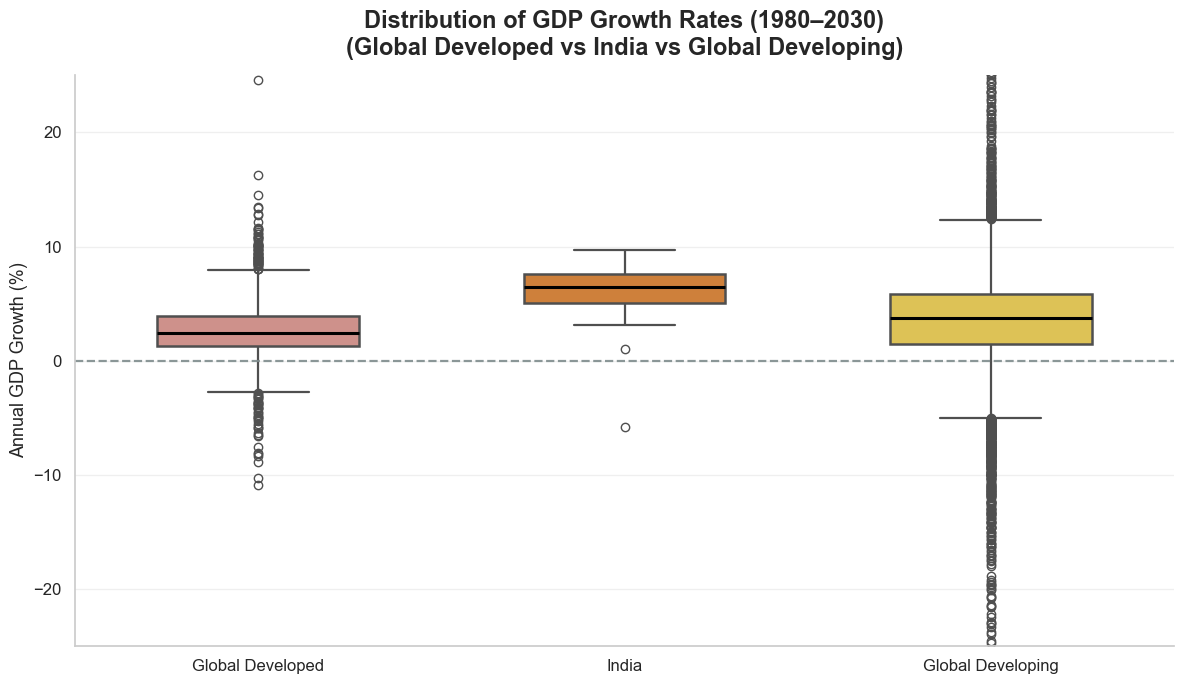

Median Annual Growth Rate:
-----------------------------------
| Category          |   GDP_Growth |
|:------------------|-------------:|
| Global Developed  |         2.38 |
| India             |         6.48 |
| Global Developing |         3.69 |
-----------------------------------


In [8]:
# 1. Prepare Data for 3-Way Comparison
# We create a copy so we don't mess up the original dataframe
plot_df = countries_df.copy()

# We overwrite the 'Category' for India rows to create a distinct group
plot_df.loc[plot_df['Country'] == 'India', 'Category'] = 'India'

# Define custome order for logical comparison
order = ['Global Developed', 'India', 'Global Developing']

# ---- Global Style ----
sns.set_theme(
    style="whitegrid",
    font="sans-serif",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "grid.alpha": 0.3
    }
)

plt.figure(figsize=(12, 7))

# Warm color palette
warm_palette = {
    'Global Developed': '#D98880',   # warm rose
    'India': '#E67E22',         # warm orange
    'Global Developing': '#F4D03F'    # soft yellow
}

# ---- Boxplot ----
sns.boxplot(
    data=plot_df,
    x='Category',
    y='GDP_Growth',
    order=order,
    palette=warm_palette,
    width=0.55,
    linewidth=1.8,
    showfliers=True,
    medianprops={"color": "black", "linewidth": 2.2},
    whiskerprops={"linewidth": 1.6},
    capprops={"linewidth": 1.6}
)

# ---- Titles & Labels ----
plt.title(
    "Distribution of GDP Growth Rates (1980–2030)\n(Global Developed vs India vs Global Developing)",
    fontsize=17,
    weight="bold",
    pad=15
)

plt.ylabel("Annual GDP Growth (%)", fontsize=13)
plt.xlabel("")

# ---- Zoom Fix ----
plt.ylim(-25, 25)

# ---- Reference Line ----
plt.axhline(
    y=0,
    color="#7f8c8d",
    linestyle="--",
    linewidth=1.6,
    alpha=0.9,
    label="Zero Growth"
)

# ---- Tick Formatting ----
plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

#  Quick Statistic: Median Comparison
print("Median Annual Growth Rate:")
print("-" * 35)
print(plot_df.groupby('Category')['GDP_Growth'].median().loc[order].to_markdown(floatfmt=".2f"))
print("-" * 35)

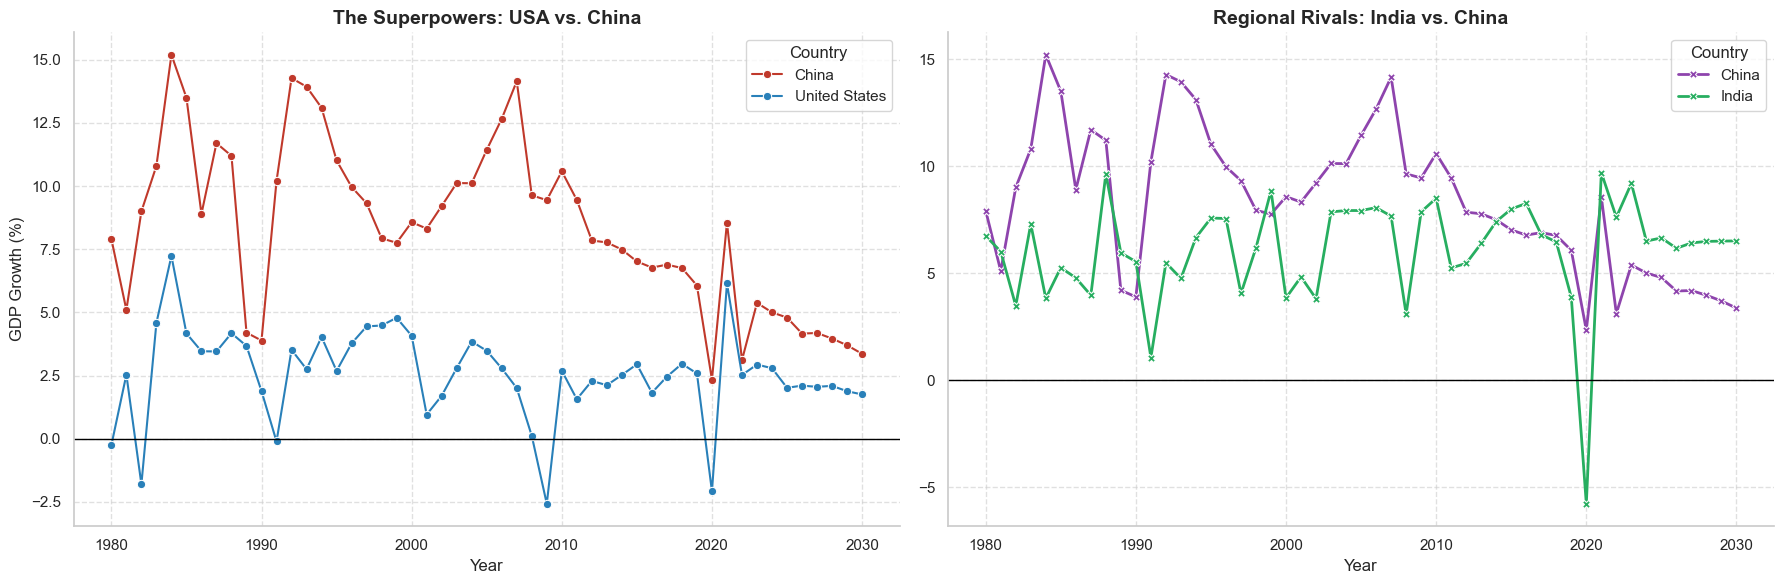

In [9]:
# 1. Setup the figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# --- CHART 1: USA vs CHINA ---
# Filter data
usa_china = countries_df[countries_df['ISO_Code'].isin(['USA', 'CHN'])]

# Plot
sns.lineplot(
    data=usa_china,
    x='Year',
    y='GDP_Growth',
    hue='Country',
    palette={'United States': '#2980b9', 'China': '#c0392b'}, # Blue for USA, Red for China
    marker='o',
    ax=axes[0]
)
axes[0].set_title('The Superpowers: USA vs. China', fontsize=14, fontweight='bold')
axes[0].set_ylabel('GDP Growth (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].axhline(0, color='black', linewidth=1) # Zero line

# --- CHART 2: INDIA vs CHINA ---
# Filter data
ind_cha = countries_df[countries_df['ISO_Code'].isin(['IND', 'CHN'])]

# Plot
sns.lineplot(
    data=ind_cha,
    x='Year',
    y='GDP_Growth',
    hue='Country',
    palette={'India': '#27ae60', 'China': '#8e44ad'}, # Green for Brazil, Purple for Argentina
    marker='X',
    linewidth=2,
    ax=axes[1]
)
axes[1].set_title('Regional Rivals: India vs. China', fontsize=14, fontweight='bold')
axes[1].set_ylabel('') # Remove label to clean up
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].axhline(0, color='black', linewidth=1) # Zero line

# Add layout spacing
plt.tight_layout()
plt.show()

# Further Analysis

In [10]:

df2 = pd.ExcelFile('S:\\Data Science\\Coursework\\Python\\Project\\IMF_WEO_Data_Organized.xlsx')


real_gdp = pd.read_excel('IMF_WEO_Data_Organized.xlsx', sheet_name='Real GDP')
per_capita = pd.read_excel('IMF_WEO_Data_Organized.xlsx', sheet_name='Per Capita GDP')
per_capita2 = pd.read_excel('IMF_WEO_Data_Organized.xlsx', sheet_name='GDP Per Capita at Current Pric ')
share_ppp = pd.read_excel('IMF_WEO_Data_Organized.xlsx', sheet_name='Share of World GDP')


In [11]:
real_gdp.head(5)

,Year,"Afghanistan, Islamic Republic of",Albania,Algeria,"Andorra, Principality of",Angola,Antigua and Barbuda,Argentina,"Armenia, Republic of","Aruba, Kingdom of the Netherlands",...,United Kingdom,United States,Uruguay,"Uzbekistan, Republic of",Vanuatu,Vietnam,West Bank and Gaza,"Yemen, Republic of",Zambia,Zimbabwe
0,2016,1222.917,1567.243,7901.391,2.572,15538.593,4.093,706.478,3369.306,5.194,...,2338.825,19141.675,1733.768,558981.724,63.635,3944143.68,59.123,237.953,129.725,58.402
1,2017,1255.288,1618.698,8019.912,2.581,15516.839,4.204,726.390,3622.609,5.375,...,2400.956,19612.100,1763.946,583550.506,66.444,4217874.76,59.962,225.884,134.271,61.440
2,2018,1270.216,1678.128,8132.190,2.622,15425.289,4.486,707.377,3811.884,5.547,...,2434.694,20193.925,1766.851,615991.221,68.371,4532739.40,60.698,227.584,139.813,64.518
3,2019,1319.902,1712.740,8205.380,2.674,15394.439,4.628,693.224,4102.782,5.616,...,2474.245,20715.650,1783.251,657754.819,70.585,4866315.60,61.525,232.363,141.770,60.433
4,2020,1288.869,1655.984,7795.111,2.375,14772.503,3.755,624.591,3811.286,4.269,...,2219.474,20284.500,1652.054,668037.900,67.062,5005755.65,54.561,212.612,137.800,55.709


In [12]:

Global_developed = [
    # G7 Countries
    'United States',
    'Canada',
    'United Kingdom',
    'Germany',
    'France',
    'Italy',
    'Japan',
    
    # Oceania & Scandinavian
    'Australia',
    'New Zealand',
    'Switzerland',
    'Norway',
    'Sweden',
    'Denmark',
    'Finland',
    
    # Western Europe
    'Iceland',
    'Ireland',
    'Netherlands, The',  # Exact name in dataset
    'Belgium',
    'Austria',
    'Spain',
    'Portugal',
    
    # Asian Tigers/Advanced Asian Economies
    'Singapore',
    'Hong Kong Special Administrative Region, People\'s Republic of China',  # Exact name
    'Israel',
    'Korea, Republic of',  # Exact name
    'Taiwan Province of China'  # Exact name
]

In [13]:
country_cols = real_gdp.columns.drop('Year')

developed_cols = [c for c in country_cols if c in Global_developed]
developing_cols = [c for c in country_cols if c not in Global_developed and c != 'India']

In [14]:
print(developing_cols)

['Afghanistan, Islamic Republic of', 'Albania', 'Algeria', 'Andorra, Principality of', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia, Republic of', 'Aruba, Kingdom of the Netherlands', 'Azerbaijan, Republic of', 'Bahamas, The', 'Bahrain, Kingdom of', 'Bangladesh', 'Barbados', 'Belarus, Republic of', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', "China, People's Republic of", 'Colombia', 'Comoros, Union of the', 'Congo, Democratic Republic of the', 'Congo, Republic of', 'Costa Rica', 'Croatia, Republic of', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Republic of', 'El Salvador', 'Equatorial Guinea, Republic of', 'Eritrea, The State of', 'Estonia, Republic of', 'Eswatini, Kingdom of', 'Ethiopia, The Federal Democratic Republic 

In [15]:
years = real_gdp['Year']

developed_gdp = real_gdp[developed_cols].sum(axis=1)
developing_gdp = real_gdp[developing_cols].sum(axis=1)
india_gdp = real_gdp['India']


This compares growth trends, not absolute size.
This is IMF / World Bank standard for trend comparison.

📌 Logic

“How fast did each group grow relative to its own starting point?”

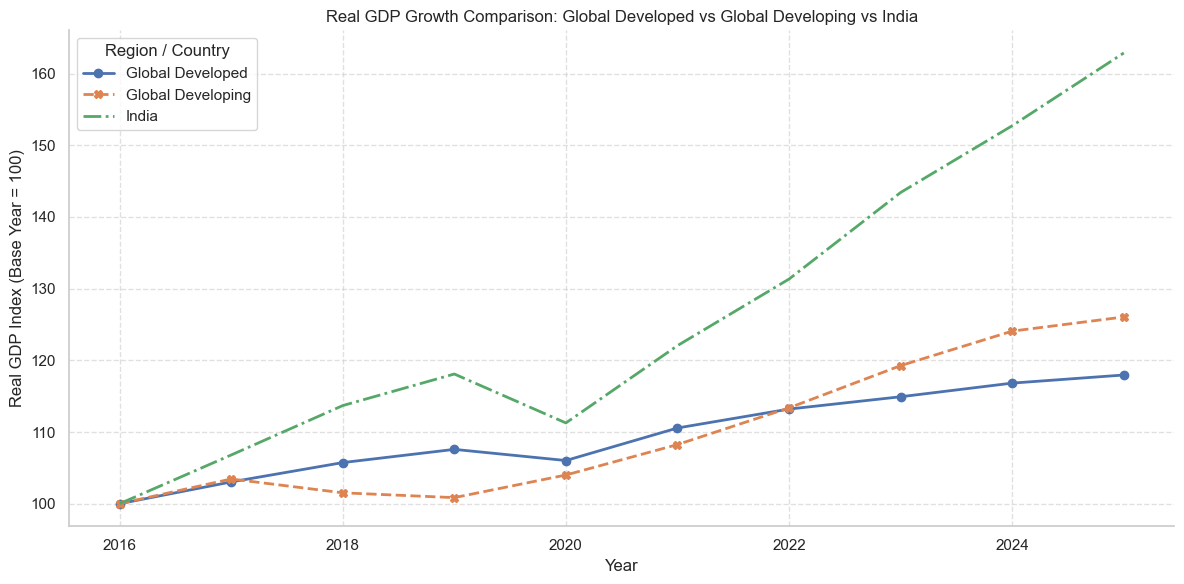

In [16]:
# Indexing (base year = first year = 100)
developed_index = developed_gdp / developed_gdp.iloc[0] * 100
developing_index = developing_gdp / developing_gdp.iloc[0] * 100
india_index = india_gdp / india_gdp.iloc[0] * 100


plt.figure(figsize=(12, 6))

# Global Developed
plt.plot(
    years,
    developed_index,
    label='Global Developed',
    linestyle='-',
    marker='o',
    linewidth=2
)

# Global Developing
plt.plot(
    years,
    developing_index,
    label='Global Developing',
    linestyle='--',
    marker='X',
    linewidth=2
)

# India
plt.plot(
    years,
    india_index,
    label='India',
    linestyle='-.',
    linewidth=2
)




# ---- Labels & title ----
plt.xlabel('Year')
plt.ylabel('Real GDP Index (Base Year = 100)')
plt.title('Real GDP Growth Comparison: Global Developed vs Global Developing vs India')

# ---- Legend formatting ----
plt.legend(title='Region / Country')

# ---- Grid ----
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



### Per Capita Analysis

In [17]:
country_cols_pc = per_capita.columns.drop('Year')

developed_cols_pc = [c for c in country_cols_pc if c in Global_developed]
developing_cols_pc = [c for c in country_cols_pc if c not in Global_developed and c != 'India']


years = per_capita['Year']

developed_pc = per_capita[developed_cols_pc].mean(axis=1)
developing_pc = per_capita[developing_cols_pc].mean(axis=1)
india_pc = per_capita['India']

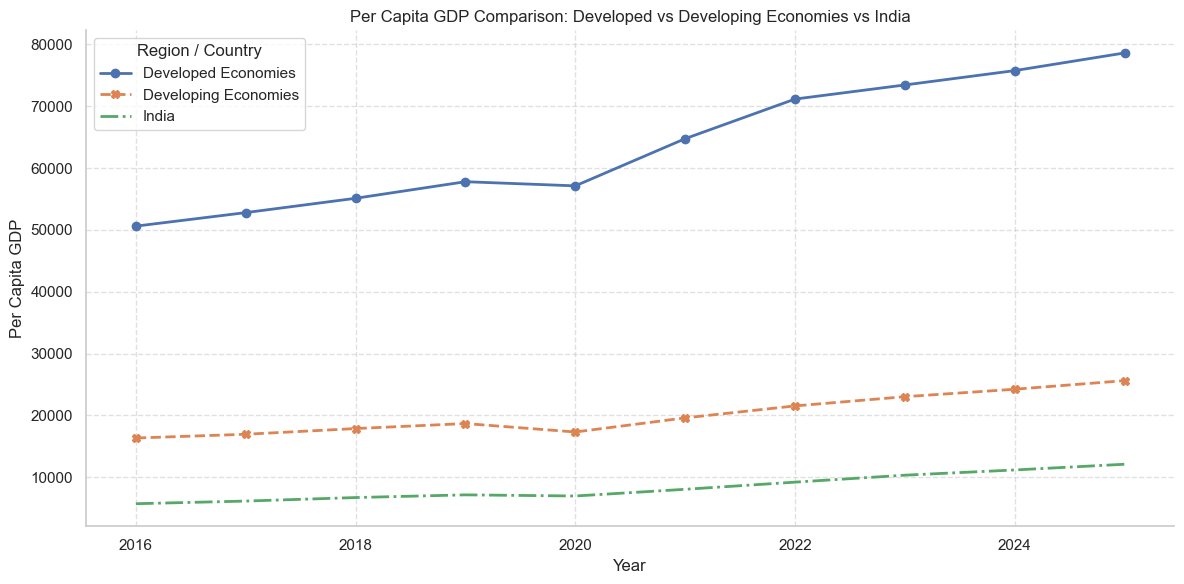

In [18]:
plt.figure(figsize=(12, 6))

# Developed Economies
plt.plot(
    years,
    developed_pc,
    label='Developed Economies',
    linestyle='-',
    marker='o',
    linewidth=2
)

# Developing Economies
plt.plot(
    years,
    developing_pc,
    label='Developing Economies',
    linestyle='--',
    marker='X',
    linewidth=2
)

# India
plt.plot(
    years,
    india_pc,
    label='India',
    linestyle='-.',
    linewidth=2
)

# ---- Labels & title ----
plt.xlabel('Year')
plt.ylabel('Per Capita GDP')
plt.title('Per Capita GDP Comparison: Developed vs Developing Economies vs India')

# ---- Legend ----
plt.legend(title='Region / Country')

# ---- Grid ----
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [19]:
print(len(developed_cols_pc), "developed countries")
print(len(developing_cols_pc), "developing countries")


26 developed countries
169 developing countries


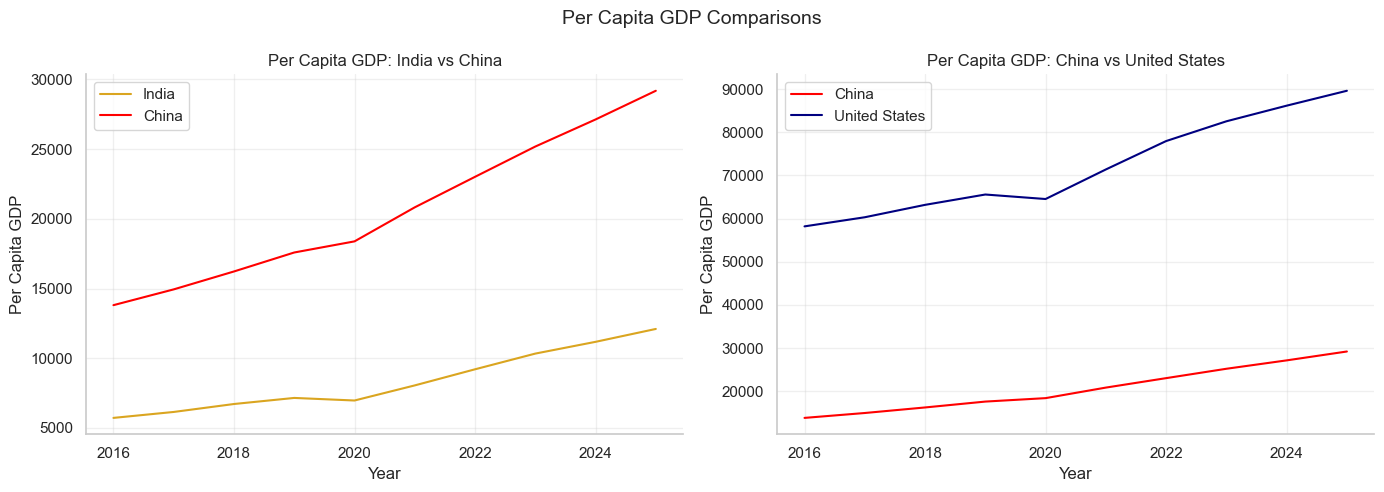

In [20]:
years = per_capita['Year']

india_pc = per_capita['India']
china_pc = per_capita['China, People\'s Republic of']
usa_pc = per_capita['United States']

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# ---- Panel 1: India vs China ----
axes[0].plot(years, india_pc, label='India', color='goldenrod')
axes[0].plot(years, china_pc, label='China', color='red')
axes[0].set_title('Per Capita GDP: India vs China')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Per Capita GDP')
axes[0].legend()
axes[0].grid(True)

# ---- Panel 2: China vs USA ----
axes[1].plot(years, china_pc, label='China', color='red')
axes[1].plot(years, usa_pc, label='United States', color='navy')
axes[1].set_title('Per Capita GDP: China vs United States')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Per Capita GDP')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Per Capita GDP Comparisons', fontsize=14)
plt.tight_layout()
plt.show()


Found 25 developed countries in dataset
Developed countries: 25
Developing countries: 172
Sample developed: ['Ireland', 'Norway', 'Denmark', 'Spain', 'United States']
Sample developing: ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola']


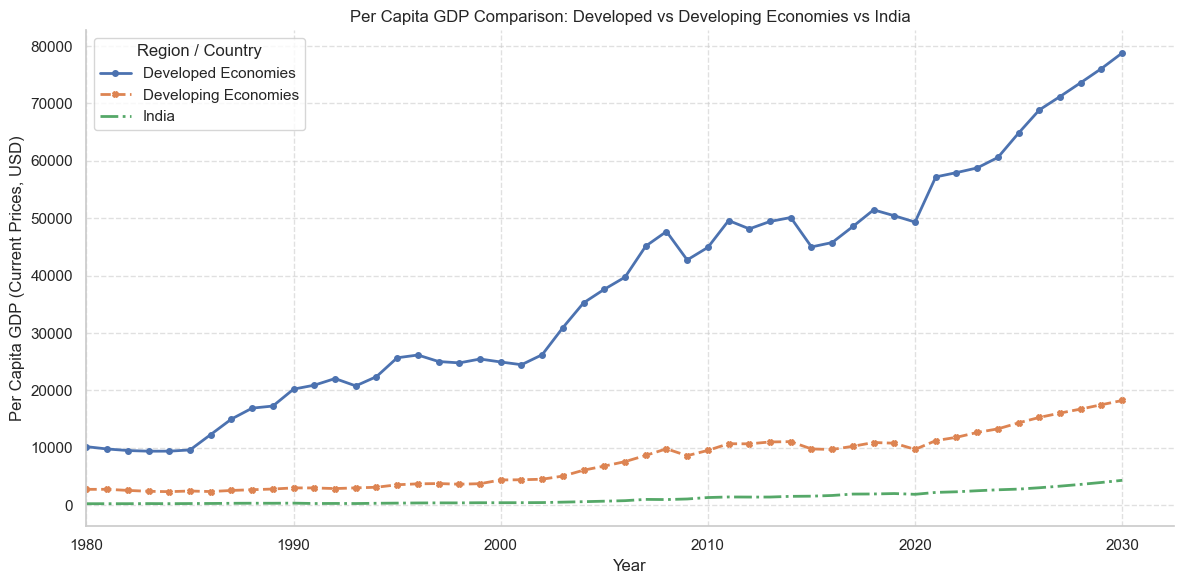

In [21]:


# First, make sure all data is numeric
# Convert the entire dataframe (except 'Years' column) to numeric
per_capita2_numeric = per_capita2.copy()

# Convert all country columns to numeric, forcing errors to NaN
country_columns = per_capita2.columns.drop('Years')
for col in country_columns:
    per_capita2_numeric[col] = pd.to_numeric(per_capita2_numeric[col], errors='coerce')

# Now proceed with your original code
years = per_capita2_numeric['Years']

# Identify developed and developing countries (check which actually exist in dataset)
country_cols_pc2 = per_capita2_numeric.columns.drop('Years')

# Clean Global_developed list - match to actual column names in dataset
Global_developed_actual = []
for country in Global_developed:
    # Check for exact match or partial match
    matches = [c for c in country_cols_pc2 if country.lower() in c.lower() or c.lower() in country.lower()]
    if matches:
        Global_developed_actual.extend(matches)
    else:
        print(f"Warning: '{country}' not found in dataset columns")

# Remove duplicates
Global_developed_actual = list(set(Global_developed_actual))
print(f"Found {len(Global_developed_actual)} developed countries in dataset")

# Create lists
developed_cols_pc2 = [c for c in Global_developed_actual]
developing_cols_pc2 = [c for c in country_cols_pc2 
                       if c not in Global_developed_actual and c != 'India']

print(f"Developed countries: {len(developed_cols_pc2)}")
print(f"Developing countries: {len(developing_cols_pc2)}")
print(f"Sample developed: {developed_cols_pc2[:5]}")
print(f"Sample developing: {developing_cols_pc2[:5]}")

# Calculate means
developed_pc2 = per_capita2_numeric[developed_cols_pc2].mean(axis=1, skipna=True)
developing_pc2 = per_capita2_numeric[developing_cols_pc2].mean(axis=1, skipna=True)
india_pc2 = per_capita2_numeric['India']

# Optional: Create indices
developed_pc2_index = developed_pc2 / developed_pc2.iloc[0] * 100 if not pd.isna(developed_pc2.iloc[0]) else developed_pc2 * np.nan
developing_pc2_index = developing_pc2 / developing_pc2.iloc[0] * 100 if not pd.isna(developing_pc2.iloc[0]) else developing_pc2 * np.nan
india_pc2_index = india_pc2 / india_pc2.iloc[0] * 100 if not pd.isna(india_pc2.iloc[0]) else india_pc2 * np.nan

# Plot
plt.figure(figsize=(12, 6))

plt.plot(years, developed_pc2, label='Developed Economies', 
         linestyle='-', marker='o', linewidth=2, markersize=4)
plt.plot(years, developing_pc2, label='Developing Economies', 
         linestyle='--', marker='X', linewidth=2, markersize=4)
plt.plot(years, india_pc2, label='India', linestyle='-.', linewidth=2)

# Handle potential NaN values at the beginning
# Find first non-NaN index for each series
valid_indices = ~(developed_pc2.isna() | developing_pc2.isna() | india_pc2.isna())
if valid_indices.any():
    start_idx = valid_indices[valid_indices].index[0]
    plt.xlim(left=years[start_idx])

plt.xlabel('Year')
plt.ylabel('Per Capita GDP (Current Prices, USD)')
plt.title('Per Capita GDP Comparison: Developed vs Developing Economies vs India')
plt.legend(title='Region / Country')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

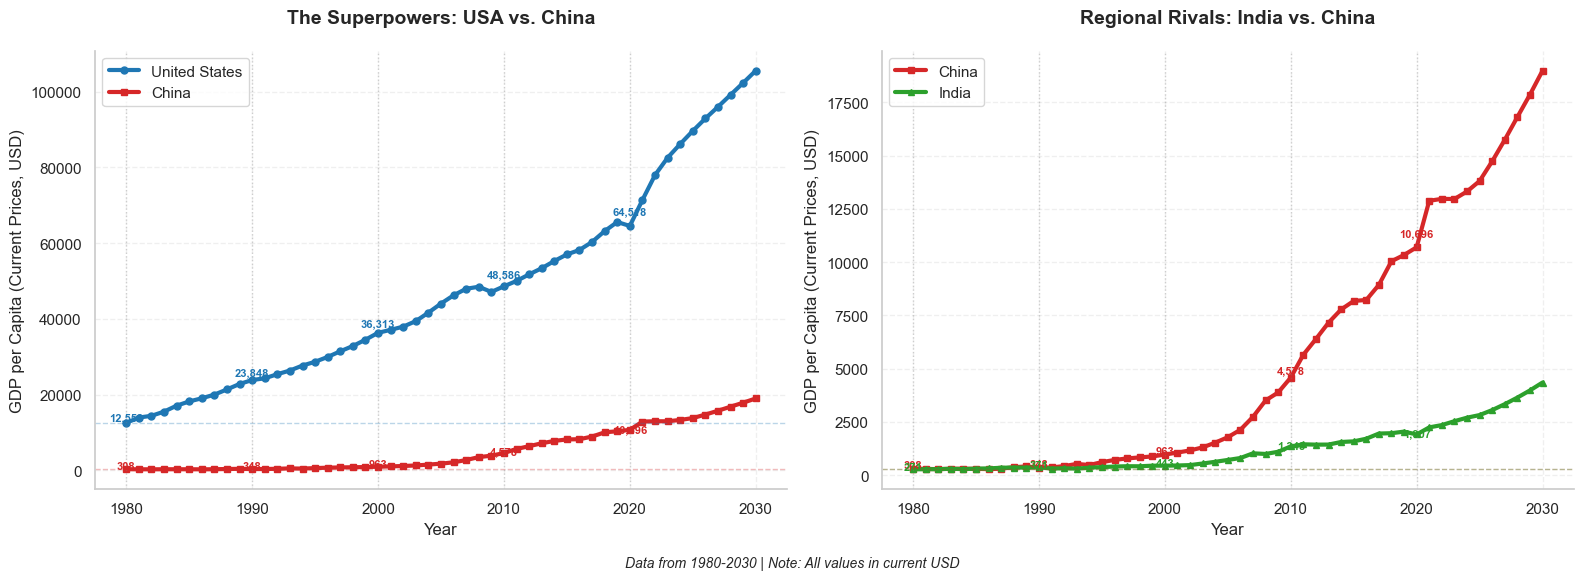

COMPARATIVE ANALYSIS STATISTICS

1. USA vs CHINA (1980-2024):
   USA:      $105,499 (Growth: 586.3%, CAGR: 4.47%)
   China:    $18,985 (Growth: 4229.3%, CAGR: 8.94%)
   Ratio (USA/China): 5.6x

2. INDIA vs CHINA (1980-2024):
   India:    $4,346 (Growth: 894.9%, CAGR: 5.36%)
   China:    $18,985 (Growth: 4229.3%, CAGR: 8.94%)
   Ratio (China/India): 4.4x

3. China overtook India in: 1980

4. KEY YEAR COMPARISON (GDP per Capita in USD):
Year   USA             China           India           USA/China    China/India 
--------------------------------------------------------------------------------
1980   $12,553         $308            $271            40.8       x 1.1        x
1990   $23,848         $348            $371            68.6       x 0.9        x
2000   $36,313         $963            $443            37.7       x 2.2        x
2010   $48,586         $4,578          $1,348          10.6       x 3.4        x
2020   $64,518         $10,696         $1,907          6.0        x 5.6    

In [ ]:
# Let's extract the data for these countries
years = per_capita2['Years']

# Get GDP per capita data for each country
usa_data = per_capita2['United States']
china_data = per_capita2['China, People\'s Republic of']
india_data = per_capita2['India']

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ============================
# LEFT SUBPLOT: USA vs China
# ============================
ax1 = axes[0]

# Plot both countries
ax1.plot(years, usa_data, color='#1f77b4', linewidth=3, label='United States', marker='o', markersize=5)
ax1.plot(years, china_data, color='#d62728', linewidth=3, label='China', marker='s', markersize=5)

# Add horizontal lines for reference
ax1.axhline(y=usa_data.iloc[0], color='#1f77b4', linestyle='--', alpha=0.3, linewidth=1)
ax1.axhline(y=china_data.iloc[0], color='#d62728', linestyle='--', alpha=0.3, linewidth=1)

# Highlight key years
for year in [1980, 1990, 2000, 2010, 2020]:
    ax1.axvline(x=year, color='gray', linestyle=':', alpha=0.3, linewidth=1)

# Adding annotations for key years
key_years = [1980, 1990, 2000, 2010, 2020]
for year in key_years:
    if year in years.values:
        idx = years[years == year].index[0]
        ax1.text(year, usa_data.iloc[idx]*1.05, f'{usa_data.iloc[idx]:,.0f}', 
                fontsize=8, ha='center', color='#1f77b4', fontweight='bold')
        ax1.text(year, china_data.iloc[idx]*0.95, f'{china_data.iloc[idx]:,.0f}', 
                fontsize=8, ha='center', color='#d62728', fontweight='bold')

# Set title and labels
ax1.set_title('The Superpowers: USA vs. China', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('GDP per Capita (Current Prices, USD)', fontsize=12)

# Add legend
ax1.legend(loc='upper left', fontsize=11, frameon=True)

# Add grid
ax1.grid(True, alpha=0.3, linestyle='--')

# ============================
# RIGHT SUBPLOT: India vs China
# ============================
ax2 = axes[1]

# Plot both countries
ax2.plot(years, china_data, color='#d62728', linewidth=3, label='China', marker='s', markersize=5)
ax2.plot(years, india_data, color='#2ca02c', linewidth=3, label='India', marker='^', markersize=5)

# Add horizontal lines for reference
ax2.axhline(y=china_data.iloc[0], color='#d62728', linestyle='--', alpha=0.3, linewidth=1)
ax2.axhline(y=india_data.iloc[0], color='#2ca02c', linestyle='--', alpha=0.3, linewidth=1)

# Highlight key years
for year in [1980, 1990, 2000, 2010, 2020]:
    ax2.axvline(x=year, color='gray', linestyle=':', alpha=0.3, linewidth=1)

# Add annotations for key years
for year in key_years:
    if year in years.values:
        idx = years[years == year].index[0]
        ax2.text(year, china_data.iloc[idx]*1.05, f'{china_data.iloc[idx]:,.0f}', 
                fontsize=8, ha='center', color='#d62728', fontweight='bold')
        ax2.text(year, india_data.iloc[idx]*0.95, f'{india_data.iloc[idx]:,.0f}', 
                fontsize=8, ha='center', color='#2ca02c', fontweight='bold')

# Set title and labels
ax2.set_title('Regional Rivals: India vs. China', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('GDP per Capita (Current Prices, USD)', fontsize=12)

# Add legend
ax2.legend(loc='upper left', fontsize=11, frameon=True)

# Add grid
ax2.grid(True, alpha=0.3, linestyle='--')

# ============================
# ADDITIONAL ANALYSIS
# ============================
# Calculate some key metrics for annotations
fig.text(0.5, 0.01, 
         f'Data from 1980-{years.iloc[-1]} | Note: All values in current USD',
         ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show plot
plt.show()

# ============================
# ADDITIONAL STATISTICS
# ============================
print("=" * 60)
print("COMPARATIVE ANALYSIS STATISTICS")
print("=" * 60)

# Calculate growth metrics
def calculate_growth(series, start_year, end_year):
    if start_year in years.values and end_year in years.values:
        start_idx = years[years == start_year].index[0]
        end_idx = years[years == end_year].index[0]
        start_val = series.iloc[start_idx]
        end_val = series.iloc[end_idx]
        growth = ((end_val - start_val) / start_val) * 100
        cagr = ((end_val / start_val) ** (1/(end_year-start_year)) - 1) * 100
        return growth, cagr
    return None, None

# USA vs China (1980-2024)
usa_growth, usa_cagr = calculate_growth(usa_data, 1980, 2024)
china_growth, china_cagr = calculate_growth(china_data, 1980, 2024)
india_growth, india_cagr = calculate_growth(india_data, 1980, 2024)

print("\n1. USA vs CHINA (1980-2024):")
print(f"   USA:      ${usa_data.iloc[-1]:,.0f} (Growth: {usa_growth:.1f}%, CAGR: {usa_cagr:.2f}%)")
print(f"   China:    ${china_data.iloc[-1]:,.0f} (Growth: {china_growth:.1f}%, CAGR: {china_cagr:.2f}%)")
print(f"   Ratio (USA/China): {usa_data.iloc[-1]/china_data.iloc[-1]:.1f}x")

print("\n2. INDIA vs CHINA (1980-2024):")
print(f"   India:    ${india_data.iloc[-1]:,.0f} (Growth: {india_growth:.1f}%, CAGR: {india_cagr:.2f}%)")
print(f"   China:    ${china_data.iloc[-1]:,.0f} (Growth: {china_growth:.1f}%, CAGR: {china_cagr:.2f}%)")
print(f"   Ratio (China/India): {china_data.iloc[-1]/india_data.iloc[-1]:.1f}x")

# Calculate when China overtook India (if it did)
for i in range(len(years)):
    if china_data.iloc[i] > india_data.iloc[i]:
        overtake_year = years.iloc[i]
        print(f"\n3. China overtook India in: {overtake_year}")
        break

# Year-by-year comparison table for key years
print("\n4. KEY YEAR COMPARISON (GDP per Capita in USD):")
print(f"{'Year':<6} {'USA':<15} {'China':<15} {'India':<15} {'USA/China':<12} {'China/India':<12}")
print("-" * 80)
for year in [1980, 1990, 2000, 2010, 2020, 2024]:
    if year in years.values:
        idx = years[years == year].index[0]
        usa_val = usa_data.iloc[idx]
        china_val = china_data.iloc[idx]
        india_val = india_data.iloc[idx]
        print(f"{year:<6} ${usa_val:<14,.0f} ${china_val:<14,.0f} ${india_val:<14,.0f} "
              f"{usa_val/china_val:<11.1f}x {china_val/india_val:<11.1f}x")